Select genes
* Foetal SAN_P cells vs other CMs (cell as replicate): logFC_threshold = 1, group_mean_threshold = 0.1
* Foetal vs Adult SAN_P cells (heart as replicate)
    - upregulated: logFC_threshold_FvsA = 1, group_mean_threshold = 0.1
    - others

In [1]:
# Parameters
working_dir = "/nfs/team205/heart/Vitro/TF_selection/foetal_SANPcell_vs_workingCM"
path_to_adata_gex = "/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw_Multiome.h5ad"
path_to_DAR_1 = "/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/MarkerPeaks/SANP-vs-aCM.csv"
path_to_DAR_2 = "/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/MarkerPeaks/aCM-vs-SANP.csv"
path_to_p2g_ArchR = ""
group_key = "fine_grain_aCMs_merged"
group_a = "SinoatrialNodePacemakerCells"
group_b = "AtrialCardiomyocytes"
subset_object = True
geneset_list = ["MSigDB_Hallmark_2020", "KEGG_2021_Human", "GO_Biological_Process_2023"]

path_to_eRegulon_signatures_gene = "/nfs/team205/heart/pyscenic/plus/eRegulon_signatures/Cardiomyocytes_Gene_eRegulon_signatures.pkl"
path_to_eRegulon_signatures_region = "/nfs/team205/heart/pyscenic/plus/eRegulon_signatures/Cardiomyocytes_Region_eRegulon_signatures.pkl"

In [77]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata

import matplotlib.pyplot as plt
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)

In [4]:
import session_info
session_info.show()

In [5]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [8]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [9]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

# Function

In [10]:
import httplib2 as http
import json
import pandas as pd

def getHGNCgroup(GID, sortby='name', print_info=True):
    # http request
    target = f'https://www.genenames.org/cgi-bin/genegroup/download?id={GID}&type=branch&format=json'
    method = 'GET'
    h = http.Http()
    response, content = h.request(target,method)

    # parses the JSON
    if response['status'] == '200':
        data = json.loads(content)
    else:
        print('Error detected: ' + response['status'])
        return None
    
    # makes lists for symbol, name, group name
    symbol = []
    name = []
    group_name = []
    hgnc = []

    # extracts these from the JSON
    for i in range(len(data)):
        symbol.append((data[i]['approvedSymbol']))
        name.append((data[i]['approvedName']))
        group_name.append((data[i]['groupName']))
        hgnc.append((data[i]['hgncID']))

    # creates a data frame from the extracted information
    group_info = {
        'symbol':symbol,
        'name':name,
        'group_name':group_name,
        'hgnc':hgnc
    }
    group_info = pd.DataFrame.from_dict(group_info).sort_values(sortby,ascending=True)

    # print all unique group names if print_info is True
    if print_info:
        unique_group_names = set(group_name)
        print(f'HGNC Group {GID}, contains:')
        for grp_name in unique_group_names:
            print(grp_name)

    return group_info

# Read in adata

In [33]:
adata = sc.read_h5ad(path_to_adata_gex)

# rename fine-grained cell types
celltype_rename = utils.read_pkl('/nfs/team205/heart/anndata_objects/Foetal/fine_grain_rename_dictionary.pkl')
adata.obs.replace({'fine_grain':celltype_rename},inplace=True)

# filter and log normalise
# filter
sc.pp.filter_genes(adata, min_cells=3)

# log normalise
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print(adata.X.data[:10])

[0.41374126 0.22811745 0.22811745 0.41374126 0.22811745 0.41374126
 0.22811745 0.41374126 0.22811745 0.22811745]


# Subset anndata

In [38]:
adata.obs['kit_10x'].value_counts()

Multiome-v1    211145
Name: kit_10x, dtype: int64

In [39]:
adata_sub = adata[adata.obs['coarse_grain']=='Cardiomyocytes']
adata_sub

View of AnnData object with n_obs × n_vars = 62104 × 34377
    obs: 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'fine_grain_aCMs_merged', 'fine_grain_aCMs-node_merged'
    var: 'gene_id', 'n_cells'
    uns: 'log1p'

In [40]:
adata_sub.var

,gene_id,n_cells
gene_name_multiome-1,,
MIR1302-2HG,ENSG00000243485,8
OR4F5,ENSG00000186092,4
AL627309.1,ENSG00000238009,771
AL627309.3,ENSG00000239945,31
AL627309.2,ENSG00000239906,4
...,...,...
AC136616.1,ENSG00000273554,4
AC023491.2,ENSG00000278633,11
AC007325.1,ENSG00000276017,12


In [41]:
adata_sub.obs.fine_grain.unique()

['VentricularCardiomyocytesLeftTrabeculated', 'AtrioventricularNodePacemakerCells', 'AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesCycling', 'VentricularCardiomyocytesCycling', ..., 'AtrialCardiomyocytesRight', 'VentricularCardiomyocytesRightCompact', 'SinoatrialNodePacemakerCells', 'VentricularCardiomyocytesRightTrabeculated', 'VentricularConductionSystemDistal']
Length: 12
Categories (12, object): ['AtrialCardiomyocytesLeft', 'AtrialCardiomyocytesRight', 'AtrialCardiomyocytesCycling', 'VentricularCardiomyocytesLeftCompact', ..., 'SinoatrialNodePacemakerCells', 'AtrioventricularNodePacemakerCells', 'VentricularConductionSystemProximal', 'VentricularConductionSystemDistal']

# DEG: SANCM vs other CMs

In [42]:
logFC_threshold = 1
group_mean_threshold = 0.1

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


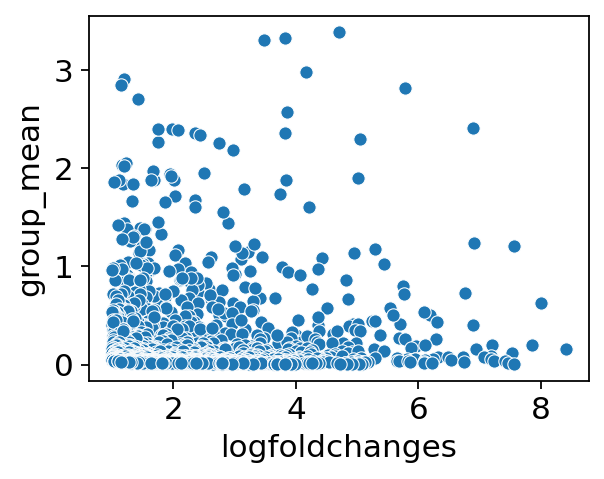

In [43]:
res = utils.rank_genes_groups_with_mean(adata_sub,
                                 groupby = 'fine_grain',
                                  groups = ['SinoatrialNodePacemakerCells'],
                                  reference = 'rest',
                                  method = 't-test',
                                  pval_cutoff = 0.05,
                                        log2fc_min=logFC_threshold
                                 )
sns.scatterplot(x=res['logfoldchanges'],y=res['group_mean'])
plt.show()

In [44]:
# filter genes based on the group mean expression
res = res[res['group_mean']>group_mean_threshold]
display(res.head())
degs_sancm_vs_others = list(res['names'])
len(degs_sancm_vs_others)

,names,scores,logfoldchanges,pvals,pvals_adj,group,group_mean
0,PLCB1,84.671532,4.711341,0.000000e+00,0.000000e+00,SinoatrialNodePacemakerCells,3.381570
1,ZNF385B,69.013870,4.159338,0.000000e+00,0.000000e+00,SinoatrialNodePacemakerCells,2.982164
2,MYH6,65.799339,3.481761,0.000000e+00,0.000000e+00,SinoatrialNodePacemakerCells,3.303232
3,CACNA1D,58.238865,5.785079,7.879214e-297,1.103147e-293,SinoatrialNodePacemakerCells,2.811245
4,RGS6,57.740051,3.851809,8.022421e-297,1.103147e-293,SinoatrialNodePacemakerCells,2.566191


675

# DEG: Foetal vs Adult

## Read in adult anndata and concatenate with foetal data

In [45]:
# prepare adult anndata
adata_adult = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_full_raw_cellstate-annotated.h5ad')

# subset SAN_P_cell
adata_adult = adata_adult[adata_adult.obs['cell_state']=='SAN_P_cell']
adata_adult = adata_adult[adata_adult.obs['kit_10x']=='Multiome-v1']

# log normalise
sc.pp.normalize_total(adata_adult, target_sum=1e4)
sc.pp.log1p(adata_adult)
print(adata_adult.X.data[:10])

# rename
adata_adult.var['gene_id'] =  adata_adult.var_names.copy()
adata_adult.var.set_index('gene_name-new',inplace=True)
adata_adult.var_names = adata_adult.var_names.astype('str')
adata_adult.var_names_make_unique()

adata_adult

[0.911473   0.31626672 0.31626672 0.31626672 0.74952203 0.911473
 0.31626672 0.31626672 0.31626672 0.31626672]


/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 245 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'gene_id'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_type_color

In [46]:
# concatenate
## shared features
shared = list(set(adata_sub.var_names).intersection(adata_adult.var_names))

adata_sub.obs['stage'] = 'foetal'
adata_adult.obs['stage'] = 'adult'
adata_adult.obs['week'] = 'adult'
adata_adult.obs['fine_grain'] = 'adult - SAN_P_cell'

adata_conc = adata_sub[:,shared].concatenate(adata_adult[:,shared],
                                             join='inner',
                                             batch_key=None,
                                             index_unique=None
                                            )

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [47]:
# combine donor and stage key
adata_conc.obs['donor_new'] = adata_conc.obs['stage'].astype('str')+'_'+adata_conc.obs['donor'].astype('str')
set(adata_conc.obs['donor_new'])

{'adult_A61',
 'adult_AH1',
 'adult_AH2',
 'adult_AV10',
 'adult_AV14',
 'adult_AV3',
 'foetal_C104',
 'foetal_C82',
 'foetal_C85',
 'foetal_C87',
 'foetal_C92',
 'foetal_C98',
 'foetal_Hst33',
 'foetal_Hst36',
 'foetal_Hst39',
 'foetal_Hst40',
 'foetal_Hst41'}

## Prepare anndata for pseudobulk wilcoxon test

In [48]:
# add drimester 
donor_trimester_df = adata_conc.obs[['donor','trimester']].copy()
donor_trimester_df = donor_trimester_df.drop_duplicates()
donor_trimester_df['trimester'] = [x if x==x else 'adult' for x in donor_trimester_df['trimester']]
donor_trimester_df

,donor,trimester
barcode,,
BHF_F_Hea11064670_BHF_F_Hea11031823_TTGCTTAGTGAGACTC-1,C82,firsttrimester
BHF_F_Hea11064671_BHF_F_Hea11031824_GTATCGCCACCTCACC-1,C85,firsttrimester
BHF_F_Hea11064672_BHF_F_Hea11031825_GTCGAAGCATGAGTTT-1,C87,firsttrimester
BHF_F_Hea11933666_BHF_F_Hea11596619_TGATGACTCGCTAAGT-1,Hst33,secondtrimester
BHF_F_Hea11933670_BHF_F_Hea11596623_GAGCTAGCAAACGGGC-1,C92,firsttrimester
BHF_F_Hea11933674_BHF_F_Hea11596627_CTTAACAAGAGGCTAA-1,C98,firsttrimester
BHF_F_Hea13188317_BHF_F_Hea13187619_AGCTAACTCTATCGCC-1,Hst41,secondtrimester
BHF_F_Hea13188328_BHF_F_Hea13187630_GCAATGTTCTAAGGTC-1,C104,firsttrimester
7089STDY13216920_BHF_F_Hea13242527_GTCTTTGTCCCTTGCG-1,Hst40,secondtrimester


In [49]:
groupby = 'donor_new'
celltypes = ['SinoatrialNodePacemakerCells','adult - SAN_P_cell']
n_cell_thresh = 10

# subset anndata
ad = adata_conc[adata_conc.obs['fine_grain'].isin(celltypes)]
# remove group which only has less than a threshold
vc = ad.obs[groupby].value_counts()
grp_to_drop = list(vc.index[vc < 10])
ad = ad[~ad.obs[groupby].isin(grp_to_drop)]
print(f'dropped groups: {grp_to_drop}')

# mean expression per group
exp_mean = utils.grouped_obs_mean(ad, group_key=groupby)

# make anndata
import anndata
adata_pb = anndata.AnnData(
    X=exp_mean.T,
    obs=pd.DataFrame(exp_mean.columns).set_index(0),
    var=pd.DataFrame(exp_mean.index).set_index(0)
)

# add stage key
adata_pb.obs['stage'] = [x.split('_')[0] for x in adata_pb.obs_names]
adata_pb.obs['stage'] = adata_pb.obs['stage'].astype('category')
adata_pb.obs['stage'].cat.reorder_categories(['foetal','adult'],inplace=True)

# add donor and trimester key
adata_pb.obs['donor'] = [x.split('_')[1] for x in adata_pb.obs_names]
obs = adata_pb.obs.reset_index().merge(donor_trimester_df,how='left',on='donor').set_index(0)
obs.index.name = 'index'
adata_pb.obs = obs
adata_pb.obs['trimester'] = adata_pb.obs['trimester'].astype('category')
adata_pb.obs['trimester'].cat.reorder_categories(['firsttrimester','secondtrimester','adult'],inplace=True)


print(adata_pb.obs['stage'].value_counts())
print(adata_pb)

dropped groups: ['foetal_C82', 'foetal_Hst36']
foetal    8
adult     6
Name: stage, dtype: int64
AnnData object with n_obs × n_vars = 14 × 30749
    obs: 'stage', 'donor', 'trimester'


/tmp/ipykernel_30942/3488307275.py:27: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_pb.obs['stage'].cat.reorder_categories(['foetal','adult'],inplace=True)
/tmp/ipykernel_30942/3488307275.py:35: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_pb.obs['trimester'].cat.reorder_categories(['firsttrimester','secondtrimester','adult'],inplace=True)


## Pseudobulk wilcoxon test

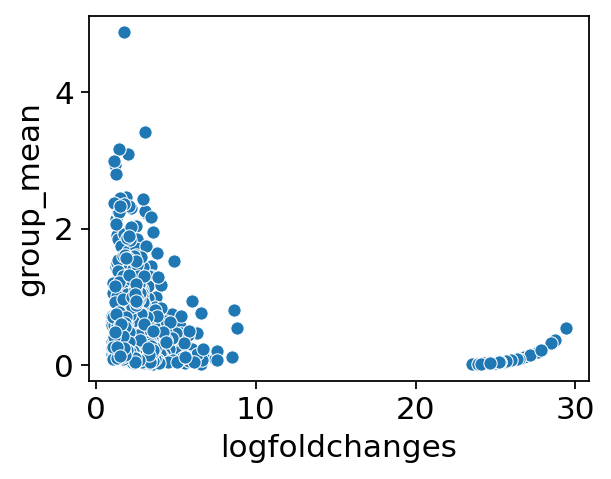

In [50]:
# rank test
logFC_threshold_FvsA = 1
group_mean_threshold = 0.1

res_foetal_vs_adult = utils.rank_genes_groups_with_mean(adata_pb,
                                 groupby = 'stage',
                                  groups = ['foetal'],
                                  reference = 'adult',
                                  method = 'wilcoxon',
                                  pval_cutoff = 0.1,
                                        log2fc_min=logFC_threshold_FvsA
                                 )

sns.scatterplot(x=res_foetal_vs_adult['logfoldchanges'],y=res_foetal_vs_adult['group_mean'])
plt.show()

In [51]:
res_foetal_vs_adult = res_foetal_vs_adult[res_foetal_vs_adult['group_mean']>group_mean_threshold]
degs_foetal_vs_adult = list(res_foetal_vs_adult['names'])
print(len(degs_foetal_vs_adult))
display(res_foetal_vs_adult.head())

620


,names,scores,logfoldchanges,pvals,pvals_adj,group,group_mean
0,PPIA,3.098387,2.366004,0.001946,0.052668,foetal,0.614792
1,ADAM11,3.098387,1.975806,0.001946,0.052668,foetal,0.349717
2,PXDN,3.098387,5.626283,0.001946,0.052668,foetal,0.214757
3,HBG1,3.098387,27.774807,0.001946,0.052668,foetal,0.206723
5,HBA2,3.098387,3.454306,0.001946,0.052668,foetal,0.275642


In [52]:
res_foetal_vs_adult[res_foetal_vs_adult['names']=='CXCL12']

,names,scores,logfoldchanges,pvals,pvals_adj,group,group_mean
333,CXCL12,3.098387,4.366289,0.001946,0.052668,foetal,0.480973


# Obtain shared DEGs

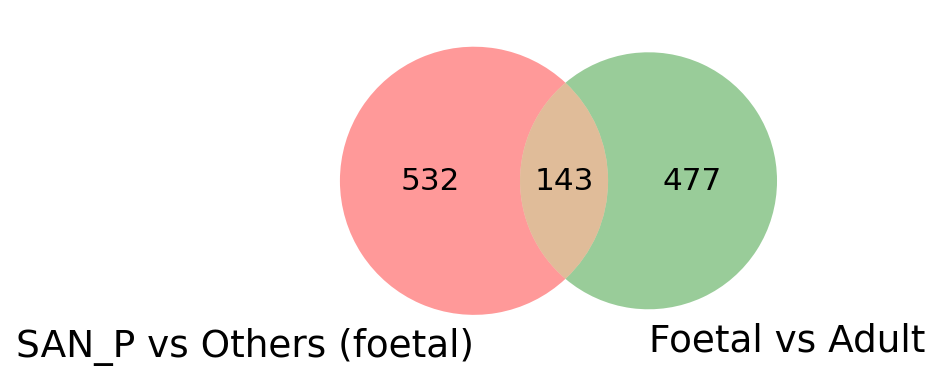

In [53]:
from matplotlib_venn import venn2
venn2(subsets=(set(degs_sancm_vs_others),set(degs_foetal_vs_adult)),
      set_labels=('SAN_P vs Others (foetal)', 'Foetal vs Adult')
     )

In [54]:
degs_common = list(set(degs_sancm_vs_others).intersection(degs_foetal_vs_adult))
len(degs_common)

143

# Pathway enrichment

In [55]:
import gseapy as gp

In [56]:
# Re-enrichmant analysis for plotting
enr_sancm_vs_othercm = gp.enrichr(gene_list=degs_sancm_vs_others,
                 gene_sets=geneset_list,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

enr_common = gp.enrichr(gene_list=degs_common,
                 gene_sets=geneset_list,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

## Plotting

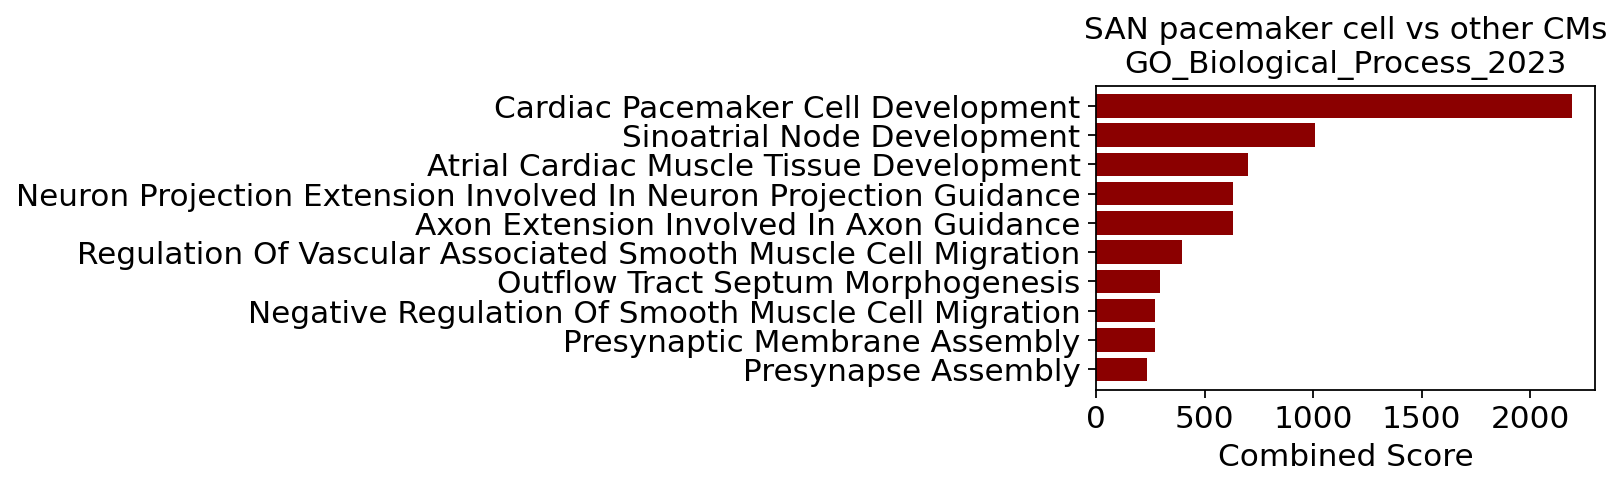

In [70]:
# foetal, SANP vs other CM
geneset = 'GO_Biological_Process_2023'

df = enr_sancm_vs_othercm.results[enr_sancm_vs_othercm.results['Gene_set'] == geneset]
df = df[df['Adjusted P-value'] < 0.1]
df = df.sort_values('Combined Score',ascending=False)

# plot
n_rank = 10
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = 4,2.5
plt.barh(width=df[:n_rank]['Combined Score'],
         y=[x.split(' (')[0] for x in df[:n_rank]['Term']],
         color='darkred')
plt.gca().invert_yaxis()
plt.xlabel('Combined Score')
plt.title(f'SAN pacemaker cell vs other CMs\n{geneset}')
plt.margins(y=0.03)
plt.savefig(f'{figdir}/Pathway-enr_SANP_sancm_vs_othercm_genes.pdf',bbox_inches="tight",dpi=300)
plt.show()

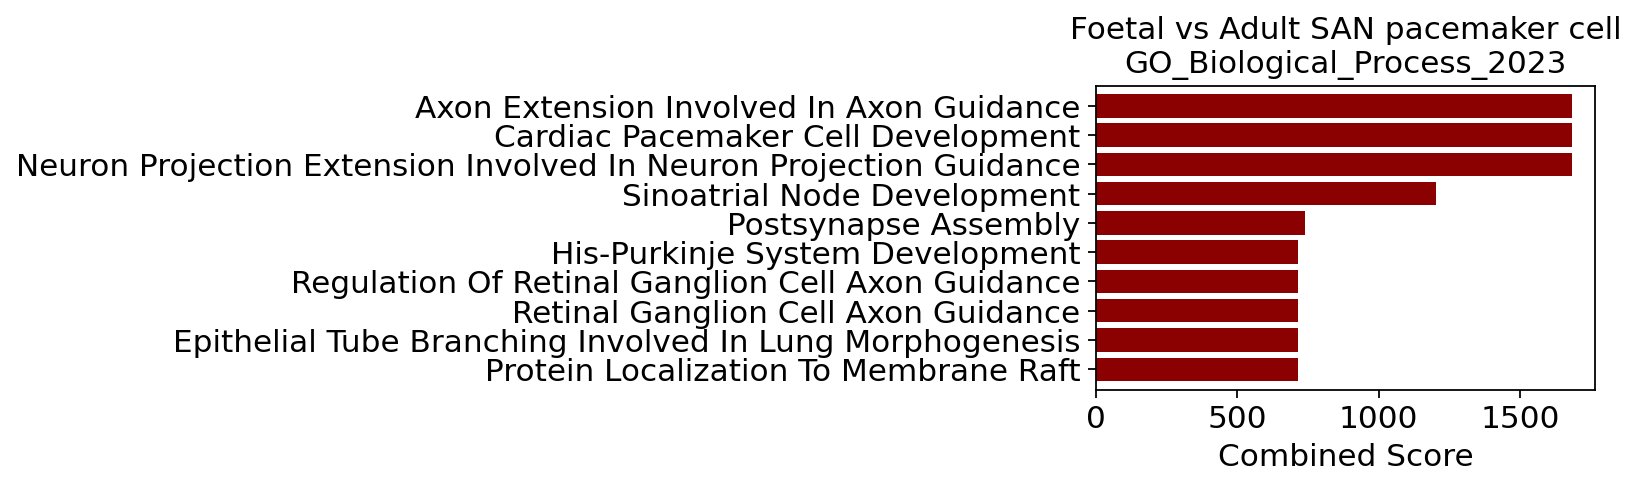

In [71]:
# foetal vs adult, SANP
geneset = 'GO_Biological_Process_2023'

df = enr_common.results[enr_common.results['Gene_set'] == geneset]
df = df[df['Adjusted P-value'] < 0.1]
df = df.sort_values('Combined Score',ascending=False)

# plot
n_rank = 10
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = 4,2.5
plt.barh(width=df[:n_rank]['Combined Score'],
         y=[x.split(' (')[0] for x in df[:n_rank]['Term']],
         color='darkred')
plt.gca().invert_yaxis()
plt.xlabel('Combined Score')
plt.title(f'Foetal vs Adult SAN pacemaker cell\n{geneset}')
plt.margins(y=0.03)
plt.savefig(f'{figdir}/Pathway-enr_SANP_common_genes.pdf',bbox_inches="tight",dpi=300)
plt.show()

# Plot axon guidance genes

In [74]:
# read in manually collected axon guidance genes
axon_genes = list(pd.read_csv('./Axon_guidance.csv')['Gene'])

# genes which is DEGs for both foetal-sancm-vs-others and foetal-vs-adult
genes_sel1 = [x for x in axon_genes if x in degs_common]
genes_sel1

['SEMA3A', 'SLIT2', 'SLIT3', 'EFNB2', 'CXCL12', 'FGF10', 'VEGFC', 'NELL1']

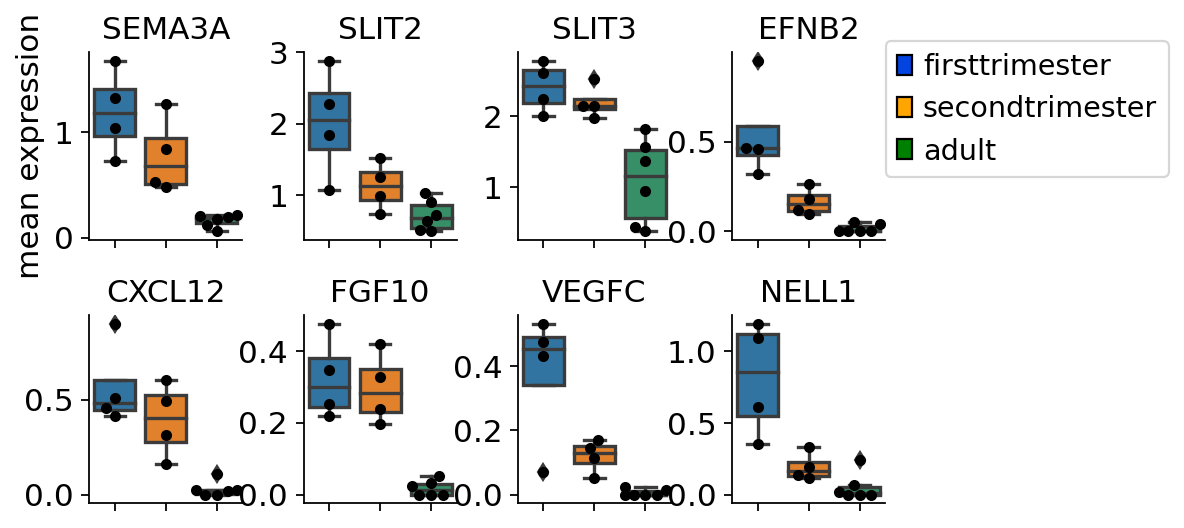

In [79]:
# plotting the genes
genes = genes_sel1.copy()

group_col = 'trimester'

data = adata_pb.to_df()[genes]
data[group_col] = adata_pb.obs[group_col]

# Melt the DataFrame to get a long-form DataFrame suitable for facetting
melted_data = data.melt(id_vars=group_col, value_vars=genes, var_name='gene', value_name='mean expression')

# Create a catplot with boxplots for each gene
g = sns.catplot(x=group_col, y='mean expression', col='gene', data=melted_data, kind='box',
                col_wrap=4, sharey=False, sharex=False, height=2, aspect=0.8)

# Overlay swarmplot on each Axes
# We'll use the 'hue' parameter to match the subsets and turn off dodge to align the points with the boxes.
for gene, ax in zip(melted_data['gene'].unique(), g.axes.flat):
    subset = melted_data[melted_data['gene'] == gene]
    sns.swarmplot(x=group_col, y='mean expression', data=subset, color='k', size=5, ax=ax, dodge=False)
    
# Update titles to remove "gene ="
for ax, gene in zip(g.axes.flat, genes):
    ax.set_title(gene)

# Rotate x-tick labels and remove x-axis labels
for i,ax in enumerate(g.axes.flat):
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels
    ax.set_xticklabels('')
    ax.set_xlabel('')  # Remove x-axis labels
    if i!=0:
        ax.set_ylabel('')

# Adjust the spacing of the plots
g.fig.subplots_adjust(wspace=0.4, hspace=0.4)

# Manually create a legend for the groups.
# Since there are no legend handles for the swarmplot, we create them manually.
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor='#0343DF', edgecolor='k', label='firsttrimester'),
                  Patch(facecolor='#FFA500', edgecolor='k', label='secondtrimester'),
                  Patch(facecolor='#008000', edgecolor='k', label='adult')]

# Add a single legend for the entire figure with our custom patches
g.fig.legend(handles=legend_patches, labels=['firsttrimester', 'secondtrimester', 'adult'], title='', loc='center', bbox_to_anchor=(1.05, 0.8))

# Show the plot
plt.savefig(f'{figdir}/Boxplot_SANPC_axon-guidance-genes.pdf',bbox_inches="tight",dpi=300)
plt.show()

# Glutermatergic signaling genes

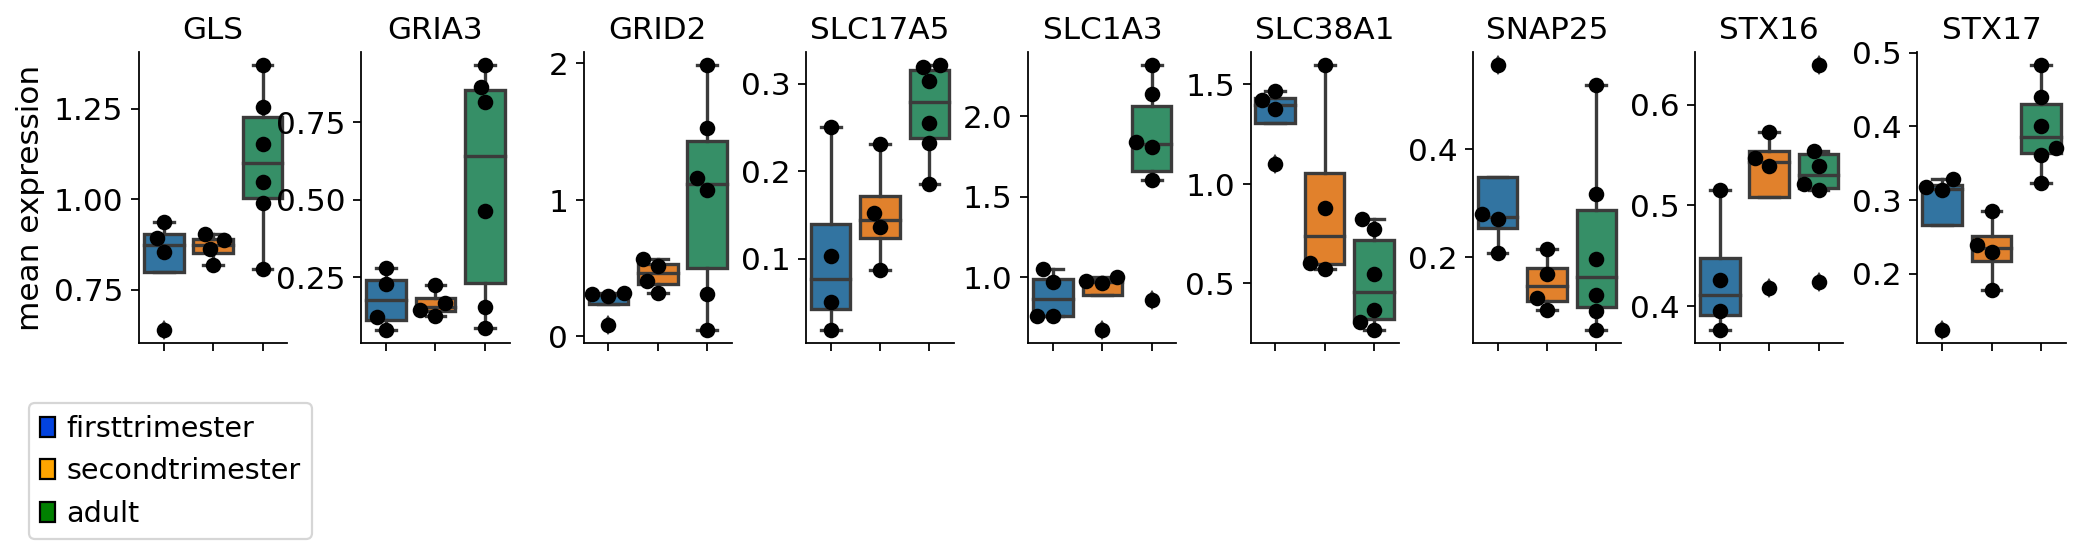

In [89]:
genes = ['GLS','GRID2','GRIA3','SLC1A3','SLC17A5','SLC38A1','SNAP25','STX16','STX17'] #'CHRM2',
genes.sort()
# genes = genes + ['GRIA1','GRIK3','GLUL','SLC1A2','SLC38A5','SLC38A9','NGF']

group_col = 'trimester'

data = adata_pb.to_df()[genes]
data[group_col] = adata_pb.obs[group_col]

# Melt the DataFrame to get a long-form DataFrame suitable for facetting
melted_data = data.melt(id_vars=group_col, value_vars=genes, var_name='gene', value_name='mean expression')

# Create a catplot with boxplots for each gene
g = sns.catplot(x=group_col, y='mean expression', col='gene', data=melted_data, kind='box',
                col_wrap=9, sharey=False, sharex=False, height=3, aspect=0.5)

# Overlay swarmplot on each Axes
# We'll use the 'hue' parameter to match the subsets and turn off dodge to align the points with the boxes.
for gene, ax in zip(melted_data['gene'].unique(), g.axes.flat):
    subset = melted_data[melted_data['gene'] == gene]
    sns.swarmplot(x=group_col, y='mean expression', data=subset, color='k', size=7, ax=ax, dodge=False)
    
# Update titles to remove "gene ="
for ax, gene in zip(g.axes.flat, genes):
    ax.set_title(gene)

# Rotate x-tick labels and remove x-axis labels
for i,ax in enumerate(g.axes.flat):
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels
    ax.set_xticklabels('')
    ax.set_xlabel('')  # Remove x-axis labels
    if i!=0:
        ax.set_ylabel('')

# Adjust the spacing of the plots
g.fig.subplots_adjust(wspace=0.5, hspace=0.2)

# Manually create a legend for the groups.
# Since there are no legend handles for the swarmplot, we create them manually.
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor='#0343DF', edgecolor='k', label='firsttrimester'),
                  Patch(facecolor='#FFA500', edgecolor='k', label='secondtrimester'),
                  Patch(facecolor='#008000', edgecolor='k', label='adult')]

# Add a single legend for the entire figure with our custom patches
g.fig.legend(handles=legend_patches, labels=['firsttrimester', 'secondtrimester', 'adult'], title='', loc='upper right', bbox_to_anchor=(0.15, 0.15))

# Show the plot
plt.savefig(f'{figdir}/Boxplot_SANPC_glutermatergic-genes.pdf',bbox_inches="tight",dpi=300)
plt.show()

# Axon guidance receptor expressions

In [91]:
LR = {
    'SEMA':['PLXNA1', 'PLXNA2', 'PLXNA3', 'PLXNA4','PLXND1'],
    'SLIT':['ROBO1','ROBO2','ROBO3','ROBO4'],
    'CXCL12':['CXCR4'],
    'NELL':['CNTNAP4'],
}

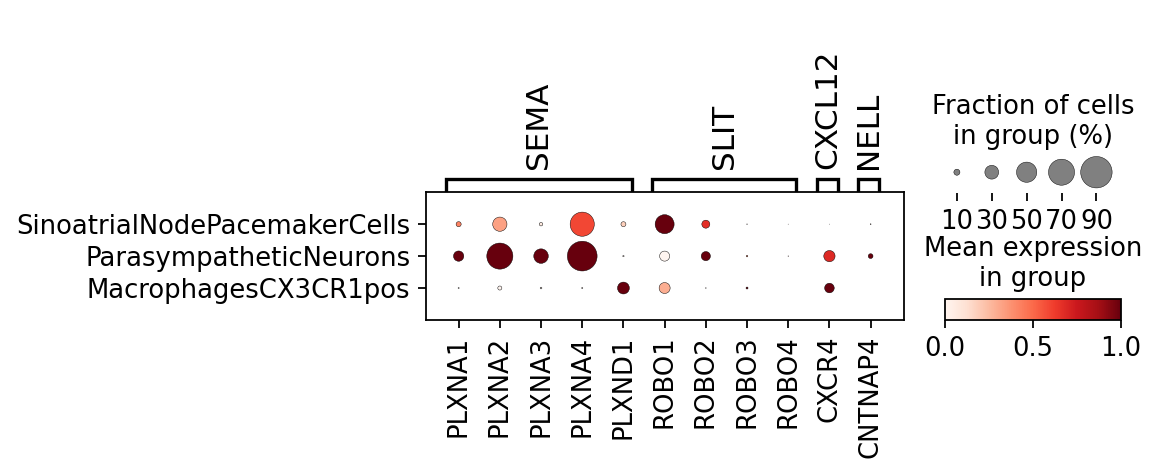

In [93]:
# at SAnode
cells = [
    'SinoatrialNodePacemakerCells',
 'ParasympatheticNeurons',
 'MacrophagesCX3CR1pos',
]

sc.pl.dotplot(adata[adata.obs['fine_grain'].isin(cells)],
              LR, 
              groupby='fine_grain',
              dendrogram=False,
              standard_scale="var",
              color_map="Reds",
              swap_axes=False,
              show=False
             )
plt.savefig(f'{figdir}/Dotplot_SAN_Axon-guidance-receptors.pdf',bbox_inches="tight",dpi=300)